In [1]:
import os
import re
import glob
import yaml

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import zarr
import napari
import tifffile
import dask.array as da

from utils.utility_functions import single_channel_pyramid

In [2]:
# Paths and input 
out = os.path.join(os.getcwd(), 'output/L5_spatial_cross-talk')
if not os.path.exists(out):
    os.makedirs(out)

sample = 'CRC-097'

tif_path = os.path.join(os.getcwd(), f'input/{sample}_image.ome.tif')
seg_path = os.path.join(os.getcwd(), f'input/{sample}_seg_outlines.ome.tif')
he_path = os.path.join(os.getcwd(), 'input/hema_eosin.ome.tif')

# Import Leiden-clustered single-cell data
data = pd.read_parquet(
    os.path.join(os.getcwd(), 'input/CRC-097_clean_cylinter_clustering_3d_leiden.parquet')
)

# Import config.yml
with open(os.path.join(os.getcwd(), 'input/CRC-97_cylinter_config.yml')) as f:
    config = yaml.safe_load(f)
markers_to_exclude = config['markersToExclude']

# Import markers.csv
markers = pd.read_csv(os.path.join(os.getcwd(), 'input/CRC-097_mcmicro_markers.csv'))

# Get name of first DNA channel
dna1 = markers['marker_name'][markers['channel_number'] == 1][0]
dna_moniker = str(re.search(r'[^\W\d]+', dna1).group())

# isolate antibodies of interest
abx_channels = [
    i for i in data.columns if 'nucleiRingMask' in i
    if 'Hoechst' not in i if i not in markers_to_exclude
]

# Import image contrast settings
with open(os.path.join(os.getcwd(), 'input/CRC-097_cylinter_contrast_limits.yml')) as f:
    contrast_limits = yaml.safe_load(f)

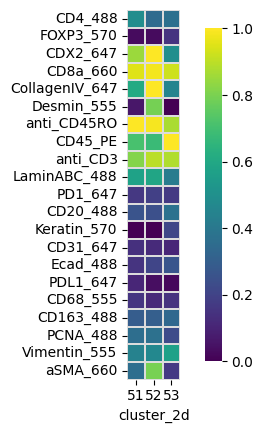

In [3]:
# Plot heatmap of L5.1, L5.2, and L5.3 mean channel intensities
slice_52 = data[data['emb2'] > 5]
ids_52 = slice_52.index[slice_52['cluster_2d'] == 5]

slice_53 = data[data['emb2'] < -6.88]
ids_53 = slice_53.index[slice_53['cluster_2d'] == 5]

slice_51 = data[(data['emb2'] <= 5) & (data['emb2'] >= -6.88)]
ids_51 = slice_51.index[slice_51['cluster_2d'] == 5]

data.loc[ids_51, 'cluster_2d'] = 51
data.loc[ids_52, 'cluster_2d'] = 52
data.loc[ids_53, 'cluster_2d'] = 53

channels = [
    'cluster_2d', 'CD4_488_nucleiRingMask', 'FOXP3_570_nucleiRingMask', 'CDX2_647_nucleiRingMask',
    'CD8a_660_nucleiRingMask', 'CollagenIV_647_nucleiRingMask', 'Desmin_555_nucleiRingMask',
    'anti_CD45RO_nucleiRingMask', 'CD45_PE_nucleiRingMask', 'anti_CD3_nucleiRingMask',
    'LaminABC_488_nucleiRingMask', 'PD1_647_nucleiRingMask', 'CD20_488_nucleiRingMask',
    'Keratin_570_nucleiRingMask', 'CD31_647_nucleiRingMask', 'Ecad_488_nucleiRingMask',
    'PDL1_647_nucleiRingMask', 'CD68_555_nucleiRingMask', 'CD163_488_nucleiRingMask',
    'PCNA_488_nucleiRingMask', 'Vimentin_555_nucleiRingMask', 'aSMA_660_nucleiRingMask'
]
clustermap_input = (
    data[channels][data['cluster_2d'].isin([51, 52, 53])]
    .groupby('cluster_2d')
    .mean()
)

# Standardize rows (0-1 scaling)
clustermap_standard = clustermap_input.apply(
    lambda x: (x - x.min()) / (x.max() - x.min()), axis=1
)

g = sns.heatmap(
    clustermap_standard.T, xticklabels=1, yticklabels=1, cmap='viridis',
    square=True, linecolor='gainsboro', linewidth=0.2, cbar_kws={'shrink': 0.9}
)
g.set_yticklabels(
        [i.get_text().split('_nucleiRingMask')[0] for i in g.get_yticklabels()], rotation=0
)
plt.savefig(os.path.join(out, 'clustermap.pdf'))
plt.show()
plt.close('all')

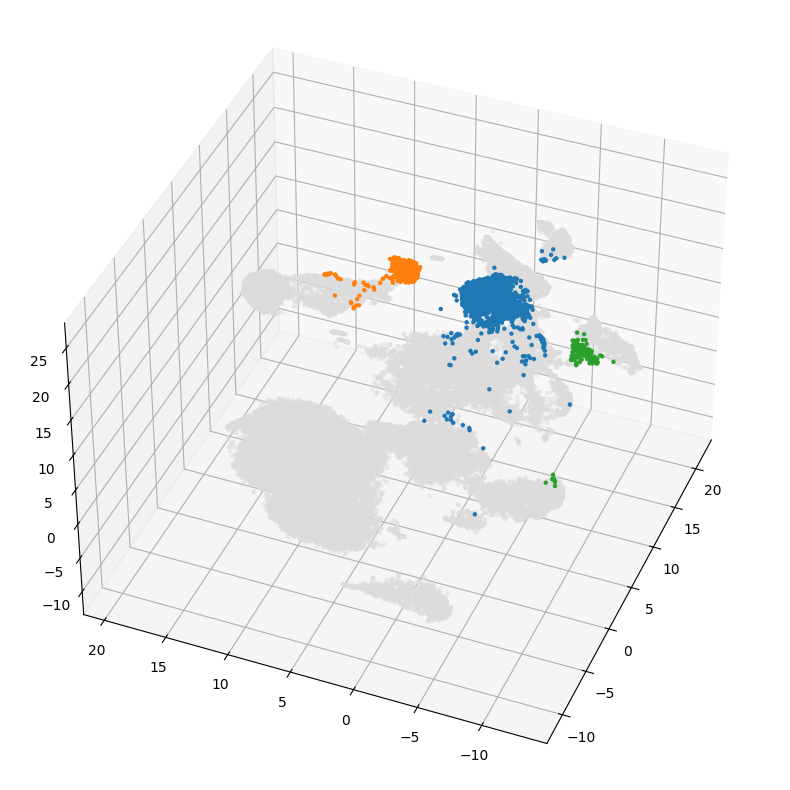

In [4]:
# View L5.1, L5.2, and L5.3 cells in 3D UMAP embedding

data_viz = data.sample(frac=0.05)

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d', computed_zorder=False)
ax.view_init(azim=-158, elev=39)

ax.scatter(
    data_viz['emb1'], data_viz['emb2'], data_viz['emb3'],
    c='gainsboro', linewidth=0.0, s=10, alpha=0.5,
)
ax.scatter(
    data_viz['emb1'][data_viz['cluster_2d'] == 51],
    data_viz['emb2'][data_viz['cluster_2d'] == 51],
    data_viz['emb3'][data_viz['cluster_2d'] == 51],
    c='tab:blue', linewidth=0.0, s=10, alpha=1,
)
ax.scatter(
    data_viz['emb1'][data_viz['cluster_2d'] == 52],
    data_viz['emb2'][data_viz['cluster_2d'] == 52],
    data_viz['emb3'][data_viz['cluster_2d'] == 52],
    c='tab:orange', linewidth=0.0, s=10, alpha=1,
)
ax.scatter(
    data_viz['emb1'][data_viz['cluster_2d'] == 53],
    data_viz['emb2'][data_viz['cluster_2d'] == 53],
    data_viz['emb3'][data_viz['cluster_2d'] == 53],
    c='tab:green', linewidth=0.0, s=10, alpha=1,
)
ax.axis('auto')
ax.tick_params(labelsize=10)
ax.grid(True)
plt.savefig(os.path.join(out, 'embedding.png'), dpi=800, bbox_inches='tight')
plt.show()
plt.close('all')

In [5]:
# Read DNA1 channel
dna, min, max = single_channel_pyramid(glob.glob(tif_path)[0], channel=0)

# Add DNA1 channel to Napari image viewer
viewer = napari.view_image(
    dna, rgb=False, blending='additive', colormap='gray', visible=True, opacity=1.0,
    name='DNA1', contrast_limits=(min, max)
)

In [6]:
# Loop over antibodies of interest and add them to Napari image viewer
for ch in abx_channels:
    ch = ch.rsplit('_', 1)[0]
    channel_number = markers['channel_number'][markers['marker_name'] == ch]
    img, min, max = single_channel_pyramid(
        glob.glob(tif_path)[0], channel=(channel_number.item() - 1)
    )

    viewer.add_image(
        img, rgb=False, blending='additive', colormap='green', visible=False,
        name=ch, contrast_limits=(min, max)
    )

# Apply previously defined contrast limits
for ch in abx_channels:
    ch = ch.rsplit('_', 1)[0]
    viewer.layers[ch].contrast_limits = (
        contrast_limits[ch][0], contrast_limits[ch][1])

In [7]:
# Add centroids of cells for each L5 subcluster to Napari image viewer
for c, cluster in zip([[0.12, 0.47, 0.71], [1.0, 0.5, 0.06], [0.17, 0.63, 0.17]], [51, 52, 53]):
    centroids = data[
        ['Y_centroid', 'X_centroid']][data['cluster_2d'] == cluster]
    viewer.add_points(
        centroids, name=f'L{cluster}', face_color=np.array(c), edge_color=c, edge_width=0.0,
        size=60.0, opacity=1.0, blending='opaque', visible=False
    )

In [8]:
# Read segmentation outlines
seg, min, max = single_channel_pyramid(glob.glob(seg_path)[0], channel=0)
viewer.add_image(
    seg, rgb=False, blending='additive', colormap='gray', visible=False,
    name='segmentation', opacity=0.3
)

<Image layer 'segmentation' at 0x165f813a0>

In [9]:
# Run Napari image viewer
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'

napari.run()